In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
# from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
from sklearn import feature_extraction,model_selection
from sklearn.metrics import confusion_matrix
import glob
import os
import string
import tensorflow as tf
import keras as K
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to C:\Users\Kirti
[nltk_data]     Mishra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: cannot import name 'plot_confusion_matrix'

In [0]:
def load_csv(path):
  df=pd.read_csv(path).drop(['Sub-task B','ID'],axis=1)
  df=df[(df['Sub-task A']=="NAG")|(df['Sub-task A']=='CAG')|(df['Sub-task A']=='OAG')].dropna()
  df['Sub-task A'] = df['Sub-task A'].map({'NAG': 0, 'CAG': 1,'OAG': 2})
  return df

In [26]:
train_df=load_csv("/content/drive/My Drive/iben_train.csv")
dev_df=load_csv("/content/drive/My Drive/iben_dev.csv")
print(train_df.head())
print(dev_df.head())

                                                Text  Sub-task A
0                                      Dada taratari           0
1                              Tumi korbe Amar sathe           0
2  Ar ta chara a sob bessha peter cheleder okhan ...           2
3                   কাকের শরীরে ময়ুরের পাখা লাগিয়েছে           1
4  পতিতাদের চরিত্র রাজনৈতিক নেতাদের থেকে হাজার গু...           0
                                                Text  Sub-task A
0  Ek dom sothik kotha bolecho jhekane theka uthe...           0
1                                        ফালতু মেয়ে           1
2                                   DARUN AKDOM THIK           0
3                                     Sala ranu magi           2
4                                থামবেল ঠিককোরে বানা           2


In [27]:
train_df.shape,dev_df.shape

((3826, 2), (957, 2))

In [28]:
print(train_df['Sub-task A'].value_counts())
print(dev_df['Sub-task A'].value_counts())

0    2078
1     898
2     850
Name: Sub-task A, dtype: int64
0    522
1    218
2    217
Name: Sub-task A, dtype: int64


In [29]:
from keras.preprocessing.text import one_hot
vocab_size = 4000000
# encode full sentence into vector
encoded_docs=[one_hot(d,vocab_size) for d in train_df['Text']]
print (encoded_docs)
encoded_docs2=[one_hot(d,vocab_size) for d in dev_df['Text']]
print (encoded_docs2)

[[2749873, 1282182], [2195325, 2057017, 3111239, 497624], [298906, 1071318, 2234568, 345085, 3614164, 1282801, 733564, 2764003, 778013, 563812, 2667998, 889371], [147501, 935872, 2517481, 1212895, 3511650], [3856231, 1059440, 1243643, 756840, 2877272, 1229919, 2436230, 3512728, 3929641, 2792923, 19632, 3762244, 3929641, 1699745, 871262, 1914923, 1567264, 3929641, 2792923, 3222286, 947789, 2998517, 3929641], [3985393, 2533667, 2809541], [1423461, 2526153, 2526153, 3043190], [3953287], [3704252, 1987468, 1711297, 1131499, 633627], [2157506, 112866, 3002213, 2277005, 466017], [2822784, 3998680, 710539, 644989, 315591, 2046144, 1938040, 791907, 2447130, 506371, 3224590, 790986], [986819, 794328, 173832, 1463918], [2694380, 2098035], [1587511, 3196886, 3557413, 81783, 3414434, 2797630, 3120783, 2082740, 3557413, 2766061, 1317946, 2475513, 670358, 3656070, 987174, 1213434, 3922056, 1543579, 2526751, 2016939, 2600882, 345085, 853287, 2392530, 2023992, 3414434, 1562319, 3558103, 996189], [1644

In [30]:
# pad documents to a max length of 4 words
max_length = 100
X_train = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(X_train)
X_test = pad_sequences(encoded_docs2, maxlen=max_length, padding='post')
print(X_test)

[[2749873 1282182       0 ...       0       0       0]
 [2195325 2057017 3111239 ...       0       0       0]
 [ 298906 1071318 2234568 ...       0       0       0]
 ...
 [1543579  832525 3843086 ...       0       0       0]
 [1782085 3196886       0 ...       0       0       0]
 [   4956 1867887 1505009 ...       0       0       0]]
[[3119840  208461 1917229 ...       0       0       0]
 [2727130  794594       0 ...       0       0       0]
 [ 361906 2559320 3985393 ...       0       0       0]
 ...
 [ 986819 2108131 1868910 ...       0       0       0]
 [3169581 3386806       0 ...       0       0       0]
 [2749873  735171 2898573 ...       0       0       0]]


In [31]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.asarray(train_df['Sub-task A']))
y_test = to_categorical(np.asarray(dev_df['Sub-task A']))
# y_train=np.array(train_df['Sub-task A'])
# y_dev=np.array(dev_df['Sub-task A'])
print(y_train.shape, y_test.shape)

(3826, 3) (957, 3)


In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Conv1D(filters = 128,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 8)            32000000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 128)           3200      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               622848    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)              

In [33]:
history=model.fit(X_train, y_train, validation_data = (X_test, y_test),epochs=100,batch_size=100, verbose=2)

Train on 3826 samples, validate on 957 samples
Epoch 1/100
 - 1s - loss: 1.0106 - acc: 0.5350 - val_loss: 0.9849 - val_acc: 0.5549
Epoch 2/100
 - 1s - loss: 0.9573 - acc: 0.5557 - val_loss: 0.9469 - val_acc: 0.5528
Epoch 3/100
 - 1s - loss: 0.8621 - acc: 0.5894 - val_loss: 0.8716 - val_acc: 0.5653
Epoch 4/100
 - 1s - loss: 0.6578 - acc: 0.7420 - val_loss: 0.8547 - val_acc: 0.6301
Epoch 5/100
 - 1s - loss: 0.4259 - acc: 0.8544 - val_loss: 0.8961 - val_acc: 0.6343
Epoch 6/100
 - 1s - loss: 0.2608 - acc: 0.9153 - val_loss: 1.0016 - val_acc: 0.6364
Epoch 7/100
 - 1s - loss: 0.1614 - acc: 0.9524 - val_loss: 1.1509 - val_acc: 0.6290
Epoch 8/100
 - 1s - loss: 0.1167 - acc: 0.9681 - val_loss: 1.2291 - val_acc: 0.6228
Epoch 9/100
 - 1s - loss: 0.0786 - acc: 0.9794 - val_loss: 1.3484 - val_acc: 0.6270
Epoch 10/100
 - 1s - loss: 0.0566 - acc: 0.9869 - val_loss: 1.4429 - val_acc: 0.6290
Epoch 11/100
 - 1s - loss: 0.0508 - acc: 0.9864 - val_loss: 1.5457 - val_acc: 0.6301
Epoch 12/100
 - 1s - loss: 

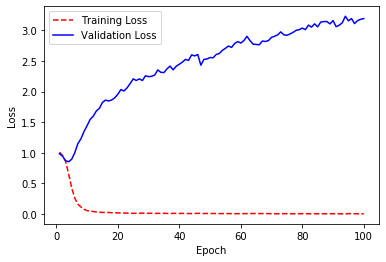

In [34]:
training_loss=history.history['loss']
validation_loss=history.history['val_loss']
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [35]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

[3.1918430702065974, 0.6332288393779982]


In [36]:
predictions_test = model.predict(X_test)
print(predictions_test)

[[1.0000000e+00 1.6893004e-12 1.5999684e-19]
 [4.3954477e-03 2.2469408e-06 9.9560237e-01]
 [9.9999928e-01 6.6570925e-07 5.2415439e-10]
 ...
 [9.9999869e-01 1.3274588e-06 4.8356754e-17]
 [9.7414565e-01 2.5840836e-02 1.3528379e-05]
 [9.9998331e-01 5.3425870e-06 1.1332639e-05]]


In [0]:
predictions_test1 = np.zeros_like(predictions_test)
predictions_test1[np.arange(len(predictions_test)), predictions_test.argmax(1)] = 1

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions_test1))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       522
           1       0.44      0.41      0.42       218
           2       0.56      0.60      0.58       217

   micro avg       0.63      0.63      0.63       957
   macro avg       0.58      0.58      0.58       957
weighted avg       0.63      0.63      0.63       957
 samples avg       0.63      0.63      0.63       957

